In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import measures

np.random.seed(0)

In [30]:
df = pd.read_csv("./../out.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [31]:
df = df.loc[400:1400] # first 1000 segments
df = df.reset_index().drop('index', axis=1)

In [32]:
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim import models

documents = df['segment'].tolist()

doc_tokenized = [simple_preprocess(doc, min_len=1, max_len=2000) for doc in documents]
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

In [ ]:
# # display word and occurence
# tfidf_doc_0 = BoW_corpus[0]
# for i in range(0, len(tfidf_doc_0)):
#     print("Word {} (\"{}\") appears {} time.".format(tfidf_doc_0[i][0], dictionary[tfidf_doc_0[i][0]], tfidf_doc_0[i][1]))

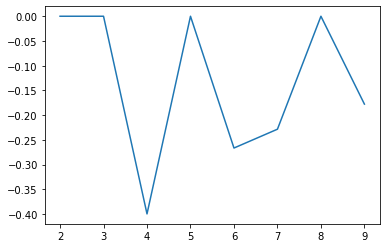

In [33]:
result_num_topic = measures.best_num_topic(corpus_tfidf, dictionary ,10)
# check get_coherence_per_topic()

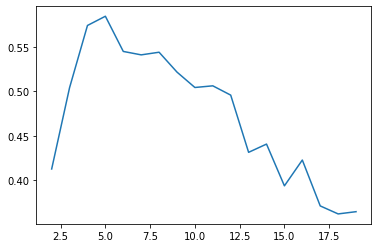

In [34]:
results = measures.best_silhouette_score(model = KMeans(), corpus = corpus_tfidf, dictionary = dictionary , max_n_clusters = 20, best_num_topic=5)
# results

In [35]:
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

Peak at k=5, silhouette_score = 0.5844141185054668


In [ ]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=best_at)
corpus_lsi = lsi_model[corpus_tfidf] 

cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
cm.get_coherence()

### Kmeans using tfidf-lsi model

In [ ]:
from gensim.matutils import corpus2csc
X_lsi = corpus2csc(corpus_lsi)

y = KMeans(n_clusters=4, random_state=0).fit_predict(X_lsi.T)

In [ ]:
pred_map = measures.label_to_cluster_num(pred=y, k=5, init_label='c')

df['modified_label'] = [pred_map[label] for label in df['label']] #map original labels to cluster numbers

pred_map

In [ ]:
kappa = measures.get_kappa(df['modified_label'], y)
rand_score = measures.get_rand_score(df['modified_label'], y)
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
silhouette = measures.get_silhouette_score(X, y)

In [ ]:
from sklearn.manifold import TSNE
tfidf_embedded = TSNE(n_components=2, 
                    perplexity=50, 
                    learning_rate = 'auto',
                    n_iter=1000, 
                    random_state=0).fit_transform(X_lsi.T) #corpus_tfidf_sparse.T

fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = y)
plt.show()

##### Kmeans with tfidf

In [ ]:
from gensim.matutils import corpus2csc

kmeans = KMeans(n_clusters=5, random_state=0)

corpus_tfidf_sparse = corpus2csc(corpus_tfidf)

kmeans_pred = kmeans.fit_predict(corpus_tfidf_sparse.T)

In [ ]:
from gensim.matutils import corpus2csc
pred_map = measures.label_to_cluster_num(pred=kmeans_pred, k=5, init_label='c')

df['modified_label'] = [pred_map[label] for label in df['label']] #map original labels to cluster numbers


In [ ]:
kappa = measures.get_kappa(df['modified_label'], kmeans_pred)
rand_score = measures.get_rand_score(df['modified_label'], kmeans_pred)
silhouette = measures.get_silhouette_score(corpus_tfidf_sparse.T, kmeans_pred)

In [ ]:
from sklearn.manifold import TSNE

tfidf_embedded = TSNE(n_components=2, 
                    perplexity=50, 
                    learning_rate = 'auto',
                    n_iter=1000, 
                    random_state=0).fit_transform(corpus_tfidf_sparse.T) #corpus_tfidf_sparse.T

fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = kmeans_pred)
plt.show()